In [2]:
# Import statements
import pandas as pd




In [4]:
# Loading in preproccessed data
PATH = "/content/drive/My Drive/Data/"

# create dataframes and keep only necessary features to join dataframes
data = pd.read_csv(PATH + "preproccessed_data.csv", lineterminator='\n')

data

,title,text,label
0,muslims busted stole millions gov ’ benefits,print pay back money plus interest entire fami...,1
1,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1
2,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1
3,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1
4,fantastic trumps 7 point plan reform healthcar...,email healthcare reform make america great sin...,1
...,...,...,...
29449,process analytical instruments market – techna...,technavio published new report global process ...,0
29450,travel deals get 1200 air credit two apt cookt...,apt offering savings new cape york outback wil...,0
29451,taiwanese recyclers belief waste simply mispla...,taipei taiwan sept 8 2015 prnewswire recent ye...,0
29452,season curtain raiser ideal way honour john,blackburn sunday league john haydock memorial ...,0


https://realpython.com/python-keras-text-classification/

In [5]:
from sklearn.model_selection import train_test_split

text = data['text'].values
label = data['label'].values

text_train, text_test, y_train, y_test = train_test_split(text, label, test_size=0.25, random_state=1000)


In [6]:
# calculate the maximum document length
def max_length(lines):
	return max([len(s.split()) for s in lines])
 
maxlen = max_length(data['text'])

In [7]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(text_train)

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


In [8]:
from keras.preprocessing.sequence import pad_sequences


X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [10]:
from keras.models import Sequential
from keras import layers

embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2202, 100)         19272700  
_________________________________________________________________
conv1d (Conv1D)              (None, 2198, 128)         64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 19,338,129
Trainable params: 19,338,129
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9990
Testing Accuracy:  0.8733


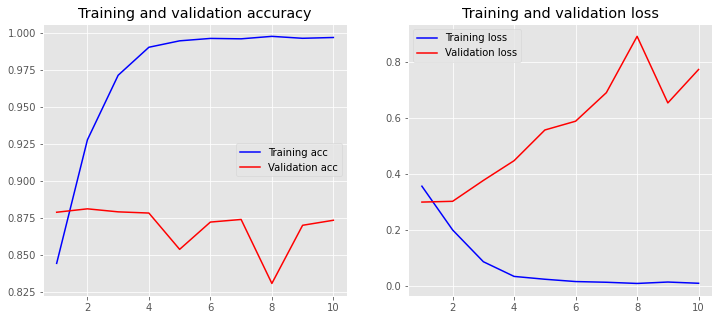

In [11]:
history = model.fit(X_train, y_train,
                    epochs = 9,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=32)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


In [12]:
from keras.models import Sequential
from keras import layers

def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(6, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [15]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size= [vocab_size], 
                  embedding_dim=[50],
                  maxlen= [maxlen])


In [17]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Run grid search for each source (yelp, amazon, imdb)
model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=16, verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=4, verbose=1, n_iter=4)
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)

# Save and evaluate results
s = ('Running data set\nBest Accuracy : {:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
output_string = s.format( grid_result.best_score_, grid_result.best_params_, test_accuracy)
print(output_string)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 142.6min finished


Running data set
Best Accuracy : 0.8664
{'vocab_size': 192727, 'num_filters': 64, 'maxlen': 2202, 'kernel_size': 7, 'embedding_dim': 50}
Test Accuracy : 0.8639




In [18]:
s = ('Running data set\nBest Accuracy : {:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
output_string = s.format( grid_result.best_score_, grid_result.best_params_, test_accuracy)
print(output_string)
       

Running data set
Best Accuracy : 0.8664
{'vocab_size': 192727, 'num_filters': 64, 'maxlen': 2202, 'kernel_size': 7, 'embedding_dim': 50}
Test Accuracy : 0.8639


